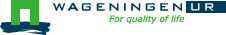



# Running PCSE/WOFOST with custom input data (1)

This Jupyter notebook will show you how to read inputs from files for running PCSE/WOFOST.

thanks to **Allard de Wit, March 2018**

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. `PCSE` and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts


## Introduction

For running PCSE/WOFOST (and PCSE models in general) with your own data sources you need three different types of inputs:

 1. Model parameters that parameterize the different model components. These parameters usually consist of a set of crop parameters (or multiple sets in case of crop rotations), a set of soil parameters and a set of site parameters. The latter provide ancillary parameters that are specific for a location, for example the initial amount of moisture in the soil.
 2. Driving variables represented by weather data which can be derived from various sources.
 3. Agromanagement actions which specify the farm activities that will take place on the field that is simulated by PCSE.

For this example we will run a simulation for sugar beet in Wageningen (Netherlands) and we will read the input data step by step from several different sources instead of using the pre-configured start_wofost() script. For the example we will assume that data files are in the `data` directory within the directory where this notebook is located. This will be the case if you downloaded the notebooks from github.


## Importing the relevant modules


In [123]:
%matplotlib inline
import sys, os
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd
import yaml

data_dir = os.path.join(os.getcwd(), "data")
import pcse
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.6.10 | packaged by conda-forge | (default, Apr  6 2020, 14:40:13) 
[GCC Clang 9.0.1 ] 
PCSE version: 5.4.2


In [48]:
import numpy as np

## Reading model parameters
### Crop parameters

The crop parameters consist of parameter names and the corresponding parameter values that are needed to parameterize the components of the crop simulation model. These are crop-specific values regarding phenology, assimilation, respiration, biomass partitioning, etc. The parameter file for sugar beet is taken from the crop files in the WOFOST Control Centre.

As many crop models in Wageningen were written in FORTRAN, the crop parameters for many models in Wageningen are often provided in the CABO format that could be read with the TTUTIL FORTRAN library. This CABO format will be gradually phased out and PCSE will move to a new format based on YAML, see [here for an example](https://github.com/ajwdewit/WOFOST_crop_parameters/blob/master/wheat.yaml). However, PCSE tries to be backward compatible as much as possible and provides the `CABOFileReader` for reading parameter files in CABO format. The `CABOFileReader` returns a dictionary with the parameter name/value pairs:

In [50]:
from pcse.fileinput import CABOFileReader
cropfile = os.path.join(data_dir, 'crop', 'sug0601.crop')
cropdata = CABOFileReader(cropfile)

In [51]:
# Number of parameters for our crop 
len(cropdata)

63

In [179]:
#cropdata['DLO'] = -99.0

In [178]:
#cropdata

### Soil parameters
The soildata dictionary provides the parameter name/value pairs related to the soil type and soil physical properties. The number of parameters is variable depending on the soil water balance type that is used for the simulation. For this example, we will use the water balance for freely draining soils and use the soil file for medium fine sand: `ec3.soil`. This file is also taken from the soil files in the [WOFOST Control Centre](http://www.wageningenur.nl/wofost).

In [53]:
soilfile = os.path.join(data_dir, 'soil', 'ec3.soil')
soildata = CABOFileReader(soilfile)

In [54]:
len(soildata)

16

In [109]:
#soildata

### Site parameters

The site parameters provide ancillary parameters that are not related to the crop or the soil. Examples are the initial conditions of the water balance such as the initial soil moisture content (WAV) and the initial and maximum surface storage (SSI, SSMAX). Also the atmospheric $CO_{2}$ 
concentration is a typical site parameter. For the moment, we can define these parameters directly on the Python commandline as a simple python dictionary. However, it is more convenient to use the `WOFOST71SiteDataProvider` that documents the site parameters and provides sensible defaults:

In [55]:
from pcse.util import WOFOST71SiteDataProvider
sitedata = WOFOST71SiteDataProvider(WAV=100, CO2=360)
print(sitedata)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 100.0, 'SMLIM': 0.4, 'CO2': 360.0}


### Packaging all parameters
Finally, we need to pack the different sets of parameters into one variable using the `ParameterProvider`. This is needed because PCSE expects one variable that contains all parameter values. Using this approach has the additional advantage that parameter value can be easily overridden in case of running multiple simulations with slightly different parameter values:

In [56]:
from pcse.base import ParameterProvider
parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

## Agromanagement
The agromanagement inputs provide the start date of the agricultural campaign, the start_date/start_type of the crop simulation, the end_date/end_type of the crop simulation and the maximum duration of the crop simulation. The latter is included to avoid unrealistically long simulations for example as a results of a too high temperature sum requirement.

The agromanagement inputs are defined with a special syntax called [YAML](http://yaml.org/) which allows to easily create more complex structures which is needed for defining the agromanagement. The agromanagement file for sugar beet in Wageningen `sugarbeet_calendar.agro` can be read with the `YAMLAgroManagementReader`:

In [79]:
from pcse.fileinput import YAMLAgroManagementReader
agromanagement_file = os.path.join(data_dir, 'agro', 'sugarbeet_calendar_Moscow_short.agro')
agromanagement = YAMLAgroManagementReader(agromanagement_file)
print(agromanagement)

!!python/object/new:pcse.fileinput.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2019-06-01:
    CropCalendar:
      crop_end_date: 2019-10-15
      crop_end_type: harvest
      crop_name: sugar-beet
      crop_start_date: 2019-06-02
      crop_start_type: emergence
      max_duration: 300
      variety_name: sugar-beet-601
    StateEvents: null
    TimedEvents:
    - comment: All fertilizer amounts in kg/ha
      event_signal: apply_npk
      events_table:
      - 2019-06-22:
          K_amount: 122
          N_amount: 128
          P_amount: 25
      name: Timed N/P/K application table



/Users/mikhailgasanov/opt/anaconda3/envs/py3_pcse/lib/python3.6/site-packages/pcse/fileinput/yaml_agro_loader.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  r = yaml.load(fp)


In [163]:
K_kg = 60
P_kg = 60
N_kg = 120
year_date=2016
yaml_agro = f"""
- {year_date}-06-01:
    CropCalendar:
        crop_name: 'sugar-beet'
        variety_name: 'sugar-beet-601'
        crop_start_date: {year_date}-06-02
        crop_start_type: emergence
        crop_end_date: {year_date}-10-15
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    -   event_signal: apply_npk
        name:  Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - {year_date}-06-22: {{N_amount : {N_kg}, P_amount: {P_kg}, K_amount: {K_kg}}}
    StateEvents: null
"""
agromanagement = yaml.load(yaml_agro)

/Users/mikhailgasanov/opt/anaconda3/envs/py3_pcse/lib/python3.6/site-packages/ipykernel_launcher.py:23: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


## Daily weather observations
Daily weather variables are needed for running the simulation. There are several data providers in PCSE for reading weather data, see the section on [weather data providers](http://pcse.readthedocs.io/en/stable/reference_guide.html#weather-data-providers) to get an overview.

For this example we will use weather data from an excel file which provides daily weather data for Wageningen for the period 2004 to 2008. We will read the data from the file using the ExcelWeatherDataProvider:

### NASA Weather Data Provider

In [42]:
#NASA Weather system
from pcse.db import NASAPowerWeatherDataProvider

In [58]:
moscow_weather = NASAPowerWeatherDataProvider(55.45, 37.36)

In [168]:
print(moscow_weather)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER SRB/FLASHFlux/MERRA2/GEOS 5.12.4 (FP-IT) 0.5 x 0.5 Degree Daily Averaged Data
----Site characteristics----
Elevation:  181.1
Latitude:  55.450
Longitude: 37.360
Data available for 1983-07-01 - 2020-04-11
Number of missing days: 8



Weather loader for __NH__ example

In [164]:
#from pcse.fileinput import ExcelWeatherDataProvider
#weatherfile = os.path.join(data_dir, 'meteo', 'nl1.xlsx')
#wdp = ExcelWeatherDataProvider(weatherfile)
#print(wdp)

## Importing, initializing and running a PCSE model

Internally, PCSE uses a simulation engine to run a crop simulation. This engine takes a configuration file that specifies the components for the crop, the soil and the agromanagement that need to be used for the simulation. So any PCSE model can be started by importing the engine and initializing it with a given configuration file and the corresponding parameters, weather data and agromanagement.

However, as many users of PCSE only need a particular configuration (for example the WOFOST model for potential production), preconfigured Engines are provided in `pcse.models`. For the sugarbeet example we will import the WOFOST model for water-limited simulation under freely draining soil conditions:

In [161]:
from pcse.models import Wofost71_WLP_FD
wofsim = Wofost71_WLP_FD(parameters, moscow_weather, agromanagement)

In [162]:
wofsim.run_till_terminate()
df_results = pd.DataFrame(wofsim.get_output())
df_results = df_results.set_index("day")
df_results.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2016-10-11,1.737843,3.074641,12945.834954,9046.237258,1737.486750,2162.110946,1697.192005,0.066815,120.0,0.300156,36.018750
2016-10-12,1.737843,3.076815,12967.580375,9065.242268,1738.574021,2163.764086,1698.250839,0.046113,120.0,0.299711,35.965264
2016-10-13,1.737843,3.078622,12985.646126,9081.031329,1739.477309,2165.137488,1699.130502,0.041048,120.0,0.299340,35.920827
2016-10-14,1.737843,3.078622,12985.646126,9081.031329,1739.477309,2165.137488,1699.130502,0.052103,120.0,0.299201,35.904162
2016-10-15,1.737843,3.078622,12985.646126,9081.031329,1739.477309,2165.137488,1699.130502,0.046475,120.0,0.298928,35.871385


We can then run the simulation and retrieve the time series of daily simulation output using the get_output() method on the WOFOST object. Finally, we convert the simulation results to a pandas dataframe:

In [82]:
summary_output = wofsim.get_summary_output()

In [83]:
wofsim.get_summary_output()

[{'DVS': 1.6528428571428562,
  'LAIMAX': 3.8835505395863263,
  'TAGP': 12666.952779048452,
  'TWSO': 8293.302919886099,
  'TWLV': 1981.2507736554403,
  'TWST': 2392.3990855069123,
  'TWRT': 1858.808469018702,
  'CTRAT': 14.75974527127402,
  'RD': 120.0,
  'DOS': None,
  'DOE': datetime.date(2019, 6, 2),
  'DOA': datetime.date(2019, 7, 19),
  'DOM': None,
  'DOH': datetime.date(2019, 10, 15),
  'DOV': None}]

In [84]:
msg = "Reached maturity at {DOM} with total biomass {TAGP} kg/ha "\
"and a yield of {TWSO} kg/ha."
print(msg.format(**summary_output[0]))

Reached maturity at None with total biomass 12666.952779048452 kg/ha and a yield of 8293.302919886099 kg/ha.


In [ ]:
#list(filter(lambda person: summary_output['name'] == 'Pam', summary_output))

In [69]:
yield_list = []

In [70]:
type(yield_list)

list

In [74]:
yield_list.append(summary_output[0]['TWSO'])

In [115]:
yield_list

[14553.678474455048,
 14553.678474455048,
 14553.678474455048,
 14553.678474455048]

In [77]:
summary_output[0]['TWSO']

14553.678474455048

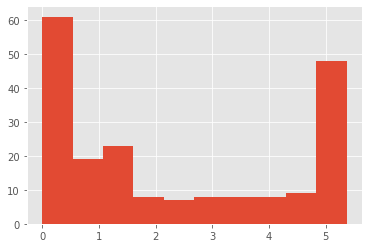

In [11]:
wofsim.run_till_terminate()
df_results = pd.DataFrame(wofsim.get_output())
df_results = df_results.set_index("day")
df_results.LAI.hist()
#print(df_results.shape)

## Visualizing simulation results

Finally, we can generate some figures of WOFOST variables such as the development (DVS), total biomass (TAGP), leaf area index (LAI) and root-zone soil moisture (SM) using the MatPlotLib plotting package:

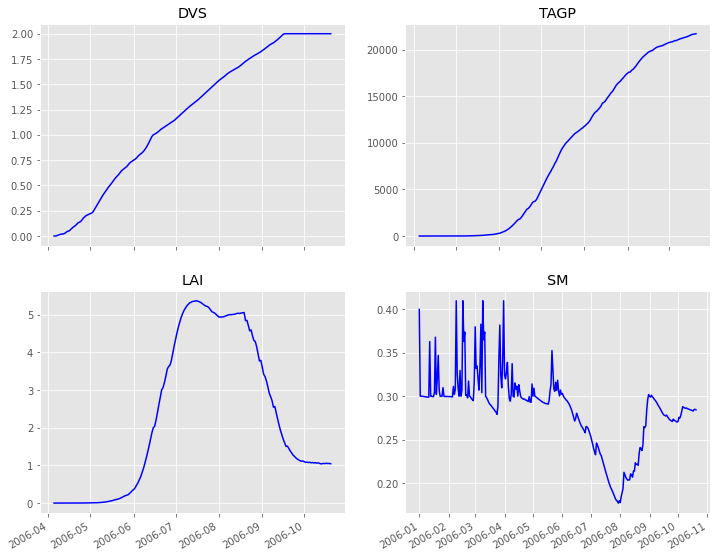

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for var, ax in zip(["DVS", "TAGP", "LAI", "SM"], axes.flatten()):
    ax.plot_date(df_results.index, df_results[var], 'b-')
    ax.set_title(var)
fig.autofmt_xdate()

# Sensitivity analysis

In this example, we will perform a Sobol’ sensitivity analysis of the Ishigami function, shown below. The Ishigami function is commonly used to test uncertainty and sensitivity analysis methods because it exhibits strong nonlinearity and nonmonotonicity.

$f(x)=\sin \left(x_{1}\right)+\operatorname{asin}^{2}\left(x_{2}\right)+b x_{3}^{4} \sin \left(x_{1}\right)$

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

Next, we must define the model inputs. The Ishigami function has three inputs, $x_{1}$,$x_{2}$,$x_{3}$ where $x_{i} \in[-\pi, \pi]$. In SALib, we define a `dict` defining the number of inputs, the names of the inputs, and the bounds on each input, as shown below.

In [21]:
problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3
}

Here, `param_values` is a NumPy matrix. If we run `param_values.shape`, we see that the matrix is **8000 by 3**. The Saltelli sampler generated 8000 samples. The Saltelli sampler generates $N∗(2D+2)$ samples, where in this example $N$ is 1000 (the argument we supplied) and $D$ is 3 (the number of model inputs). The keyword argument `calc_second_order=False` will exclude second-order indices, resulting in a smaller sample matrix with $N∗(D+2)$ rows instead.


In [23]:
# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model (example)
Y = Ishigami.evaluate(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)
T_Si, first_Si, (idx, second_Si) = sobol.Si_to_pandas_dict(Si)

Parameter S1 S1_conf ST ST_conf
x1 0.307975 0.063769 0.560137 0.084886
x2 0.447767 0.056001 0.438722 0.040663
x3 -0.004255 0.058466 0.242845 0.024166

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.012205 0.088213
x1 x3 0.251526 0.106417
x2 x3 -0.009954 0.067973


## Morris plot


Generate a sample using the Method of Morris

Three variants of Morris' sampling for elementary effects is supported:

- Vanilla Morris
- Optimised trajectories when ``optimal_trajectories=True`` (using
    Campolongo's enhancements from 2007 and optionally Ruano's enhancement
    from 2012; ``local_optimization=True``)
- Groups with optimised trajectories when ``optimal_trajectories=True`` and
    the problem definition specifies groups (note that ``local_optimization``
    must be ``False``)

At present, optimised trajectories is implemented using either a brute-force
approach, which can be very slow, especially if you require more than four
trajectories, or a local method based which is much faster. Both methods now
implement working with groups of factors.

Note that the number of factors makes little difference,
but the ratio between number of optimal trajectories and the sample size
results in an exponentially increasing number of scores that must be
computed to find the optimal combination of trajectories.  We suggest going
no higher than 4 from a pool of 100 samples with the brute force approach.
With local_optimization = True (which is default),
it is possible to go higher than the previously suggested 4 from 100.



Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
x1                                  2.636     -0.159           0.055      2.756
x2                                  1.424      0.126           0.051      1.614
x3                                  0.601     -0.022           0.020      0.697
x4                                  0.339      0.003           0.012      0.397
x5                                  0.034      0.000           0.001      0.040
x6                                  0.034     -0.001           0.001      0.040
x7                                  0.035     -0.000           0.001      0.041
x8                                  0.035      0.001           0.001      0.041


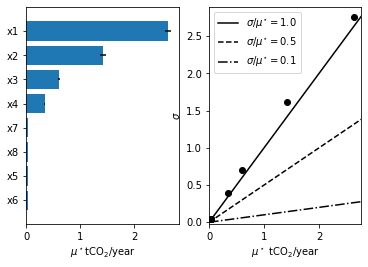

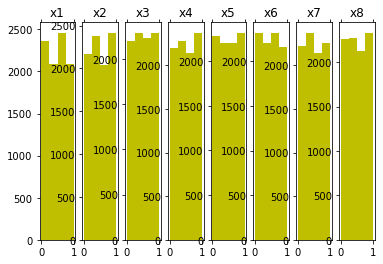

In [18]:
import sys

from SALib.analyze import morris
from SALib.sample.morris import sample
from SALib.test_functions import Sobol_G
from SALib.util import read_param_file
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms
import matplotlib.pyplot as plt

#sys.path.append('../..')

# Read the parameter range file and generate samples
#problem = read_param_file('/Users/mikhailgasanov/Documents/GIT/SALib/src/SALib/test_functions/params/Sobol_G.txt')
# or define manually without a parameter file:
problem = {
 'num_vars': 8,
 'names': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
 'groups': None,
 'bounds': [[0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0]]
}
# Files with a 4th column for "group name" will be detected automatically, e.g.
# param_file = '../../src/SALib/test_functions/params/Ishigami_groups.txt'

# Generate samples
param_values = sample(problem, N=1000, num_levels=4,
                      optimal_trajectories=None)

# To use optimized trajectories (brute force method),
# give an integer value for optimal_trajectories

# Run the "model" -- this will happen offline for external models
Y = Sobol_G.evaluate(param_values)

# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
Si = morris.analyze(problem, param_values, Y, conf_level=0.95,
                    print_to_console=True,
                    num_levels=4, num_resamples=100)
# Returns a dictionary with keys 'mu', 'mu_star', 'sigma', and 'mu_star_conf'
# e.g. Si['mu_star'] contains the mu* value for each parameter, in the
# same order as the parameter file

fig, (ax1, ax2) = plt.subplots(1, 2)
horizontal_bar_plot(ax1, Si, {}, sortby='mu_star', unit=r"tCO$_2$/year")
covariance_plot(ax2, Si, {}, unit=r"tCO$_2$/year")

fig2 = plt.figure()
sample_histograms(fig2, param_values, problem, {'color': 'y'})
plt.show()

## Simple tool for Sobol' seq and LHS sample visualization for sensitivity analysis

How to repeat: [Repo](https://github.com/charlesrouge/SampleVis)